In [192]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..') 

from src.cleaning import remove_group_outliers, load_and_clean_data


In [193]:

# Load dataset
df = load_and_clean_data()



## Prepare Data for Modeling (Split & Scale)

Tasks:
* Add engineered features
* Split the data into features (X) and target (y).
* Train-test split: Reserve some data for testing the model after training.
* Scale numeric features.

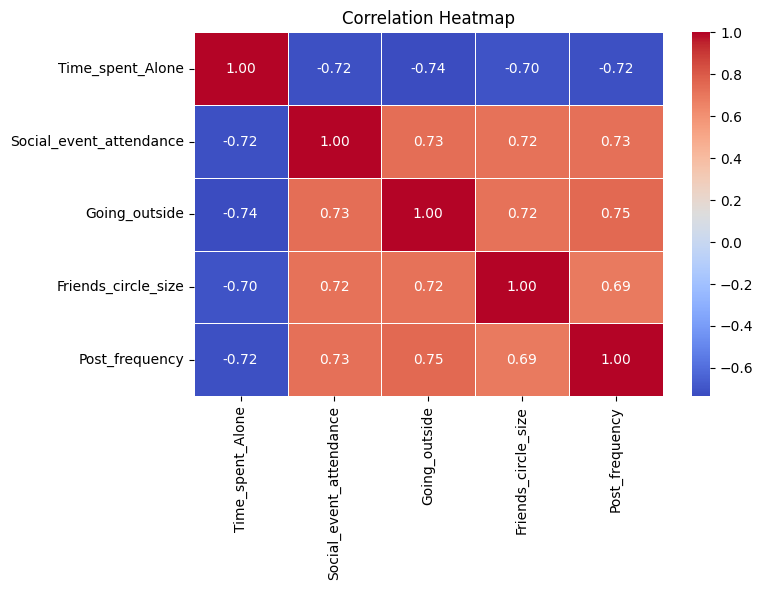

                         Time_spent_Alone  Social_event_attendance  \
Time_spent_Alone                 1.000000                -0.718139   
Social_event_attendance         -0.718139                 1.000000   
Going_outside                   -0.735247                 0.731941   
Friends_circle_size             -0.701665                 0.718518   
Post_frequency                  -0.718072                 0.727732   

                         Going_outside  Friends_circle_size  Post_frequency  
Time_spent_Alone             -0.735247            -0.701665       -0.718072  
Social_event_attendance       0.731941             0.718518        0.727732  
Going_outside                 1.000000             0.718327        0.754758  
Friends_circle_size           0.718327             1.000000        0.690381  
Post_frequency                0.754758             0.690381        1.000000  


In [194]:
numeric_features = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                    'Friends_circle_size', 'Post_frequency']

corr = df[numeric_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title(f'Correlation Heatmap')
plt.tight_layout()
plt.show()

print(corr)


In [195]:
# Drop label columns used for plotting if present
for col in ['Personality_label', 'Stage_fear_label', 'Drained_after_socializing_label']:
    if col in df.columns:
        df = df.drop(columns=[col])

# Define X and y
X = df.drop(columns=['Personality'])
y = df['Personality']

# Scale numeric features
numeric_features = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                    'Friends_circle_size', 'Post_frequency']
print(df.size)
df = remove_group_outliers(df, group_col='Personality', numeric_cols= numeric_features)
print(df.size)



23200
21768


In [197]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



scaler = StandardScaler()


X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])




## 🧪 Train and Compare Multiple Models

Goal: Train a few different models and compare their accuracy side-by-side.
1. Logistic Regression 
2. K-Nearest Neighbors (KNN)
3. Support Vector Machine (SVM)
4. Random Forest
5. XGBoost 

#### 📊 Create helper functions for hyperparameters, and to train and evaluate

In [198]:
# Helper function to train and evaluate
def evaluate_model(name, model, X_train, X_test, y_train, y_test, results):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    results.append((name, acc))

In [199]:
def find_best_k(X_train, y_train, max_k=20):
    k_values = range(1, max_k + 1)
    cv_scores = []

    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())

    best_k = k_values[cv_scores.index(max(cv_scores))]

    return best_k



#### 🚀 Train the models:

In [200]:
results = []

evaluate_model("Logistic Regression", LogisticRegression(), X_train, X_test, y_train, y_test, results)

best_k = find_best_k(X_train, y_train)
evaluate_model("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=21), X_train, X_test, y_train, y_test, results)

evaluate_model("SVM", SVC(kernel='rbf', gamma='scale'), X_train, X_test, y_train, y_test, results)

evaluate_model("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42), X_train, X_test, y_train, y_test, results)

evaluate_model("XGBoost", xgb.XGBClassifier(eval_metric='logloss'), X_train, X_test, y_train, y_test, results)


Logistic Regression Accuracy: 0.9172
K-Nearest Neighbors Accuracy: 0.9241
SVM Accuracy: 0.9241
Random Forest Accuracy: 0.9086
XGBoost Accuracy: 0.9103


#### 📈 Plot the results:

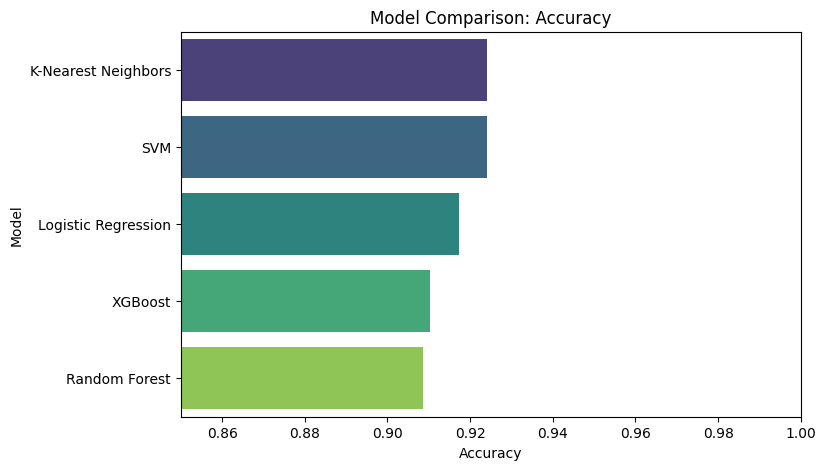

,Model,Accuracy
1,K-Nearest Neighbors,0.924138
2,SVM,0.924138
0,Logistic Regression,0.917241
4,XGBoost,0.910345
3,Random Forest,0.908621


In [201]:
# Turn into DataFrame for comparison
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="Accuracy", y="Model", palette="viridis", hue="Model", legend=False)
plt.title("Model Comparison: Accuracy")
plt.xlim(0.85, 1.00)
plt.show()

results_df

## 🔎 Step 7 — Feature Importance 

### Model 1: Logistic Regression

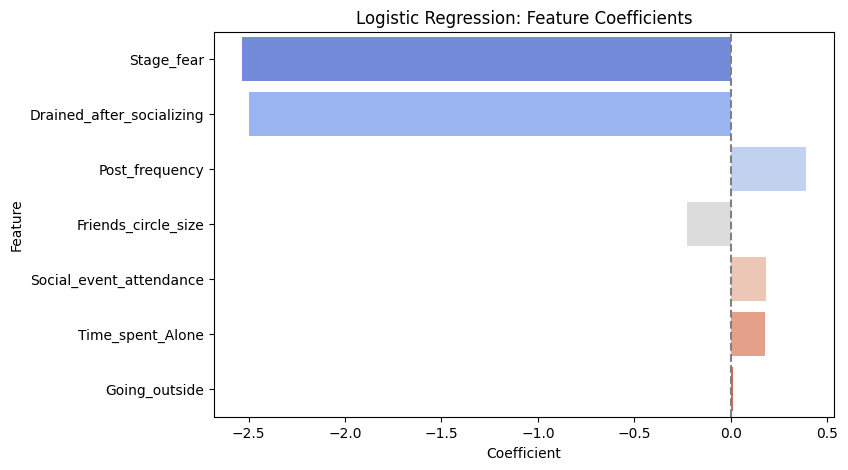

,Feature,Coefficient,Importance (Abs)
1,Stage_fear,-2.534131,2.534131
4,Drained_after_socializing,-2.496593,2.496593
6,Post_frequency,0.389224,0.389224
5,Friends_circle_size,-0.224471,0.224471
2,Social_event_attendance,0.184453,0.184453
0,Time_spent_Alone,0.179190,0.179190
3,Going_outside,0.011731,0.011731


In [202]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_model.coef_[0],
    'Importance (Abs)': abs(log_model.coef_[0])
}).sort_values(by='Importance (Abs)', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=log_coef_df, x='Coefficient', y='Feature', palette='coolwarm', hue='Feature', legend=False)
plt.axvline(0, color='gray', linestyle='--')
plt.title('Logistic Regression: Feature Coefficients')
plt.show()

log_coef_df

### Model 2: Random Forest

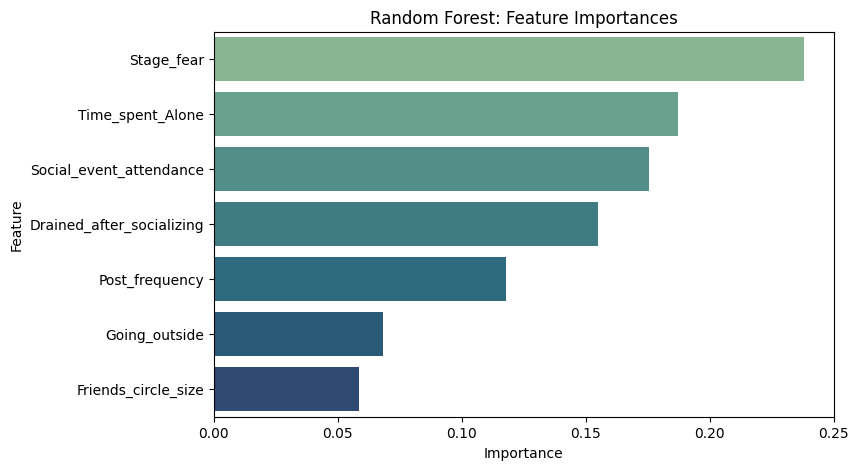

,Feature,Importance
1,Stage_fear,0.238145
0,Time_spent_Alone,0.187170
2,Social_event_attendance,0.175286
4,Drained_after_socializing,0.154786
6,Post_frequency,0.117841
3,Going_outside,0.068242
5,Friends_circle_size,0.058530


In [203]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=rf_df, x='Importance', y='Feature', hue='Feature', palette='crest', legend=False)
plt.title('Random Forest: Feature Importances')
plt.show()

rf_df



### Model 3: XGBoost

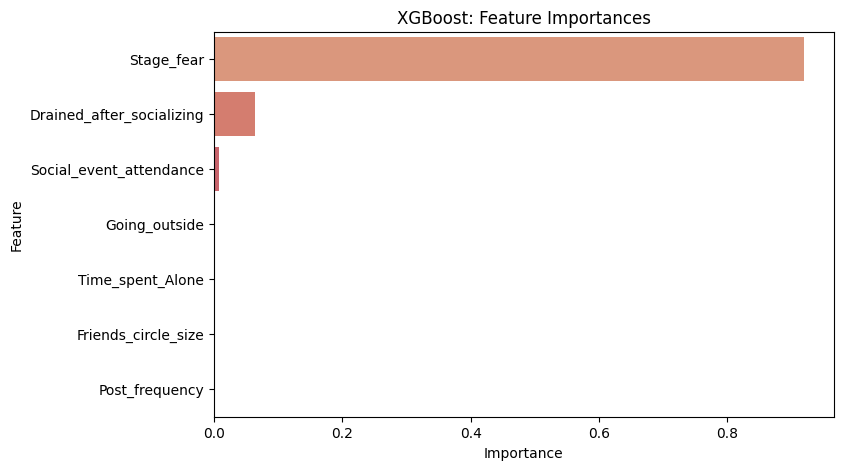

,Feature,Importance
1,Stage_fear,0.920230
4,Drained_after_socializing,0.064544
2,Social_event_attendance,0.008489
3,Going_outside,0.001850
0,Time_spent_Alone,0.001843
5,Friends_circle_size,0.001556
6,Post_frequency,0.001487


In [207]:

xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=xgb_df, x='Importance', y='Feature', palette='flare', hue='Feature')
plt.title('XGBoost: Feature Importances')
plt.show()

xgb_df


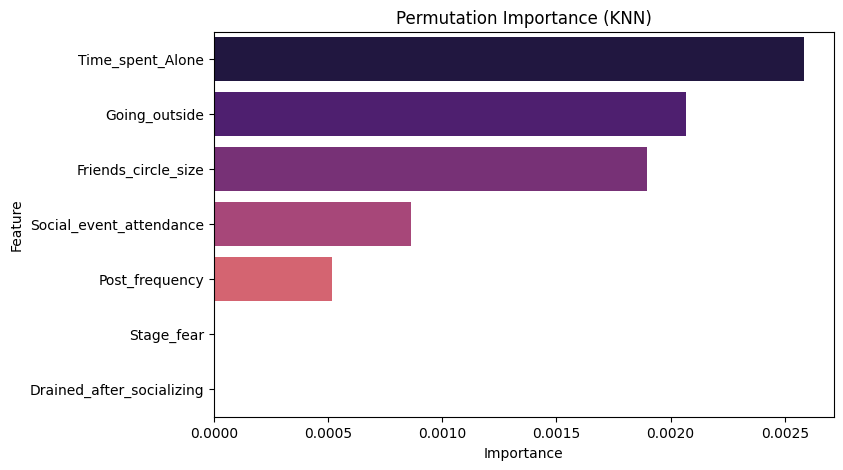

,Feature,Importance
0,Time_spent_Alone,0.002586
3,Going_outside,0.002069
5,Friends_circle_size,0.001897
2,Social_event_attendance,0.000862
6,Post_frequency,0.000517
1,Stage_fear,0.000000
4,Drained_after_socializing,0.000000


In [208]:
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)
perm_result = permutation_importance(knn_model, X_test, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=perm_df, x='Importance', y='Feature', palette='magma', hue='Feature')
plt.title('Permutation Importance (KNN)')
plt.show()

perm_df


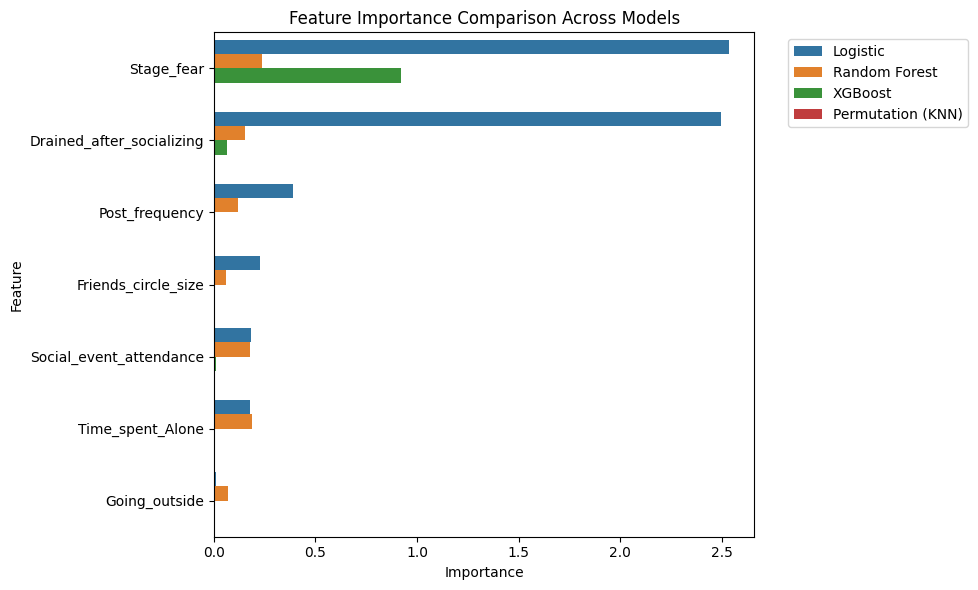

,Feature,Logistic,Random Forest,XGBoost,Permutation (KNN)
0,Stage_fear,2.534131,0.238145,0.920230,0.000000
1,Drained_after_socializing,2.496593,0.154786,0.064544,0.000000
2,Post_frequency,0.389224,0.117841,0.001487,0.000517
3,Friends_circle_size,0.224471,0.058530,0.001556,0.001897
4,Social_event_attendance,0.184453,0.175286,0.008489,0.000862
5,Time_spent_Alone,0.179190,0.187170,0.001843,0.002586
6,Going_outside,0.011731,0.068242,0.001850,0.002069


In [209]:
logreg_df = log_coef_df[['Feature', 'Importance (Abs)']].rename(columns={'Importance (Abs)': 'Logistic'})
rf_df = rf_df.rename(columns={'Importance': 'Random Forest'})
xgb_df = xgb_df.rename(columns={'Importance': 'XGBoost'})
perm_df = perm_df.rename(columns={'Importance': 'Permutation (KNN)'})

combined = logreg_df.merge(rf_df, on='Feature') \
                    .merge(xgb_df, on='Feature') \
                    .merge(perm_df, on='Feature')

melted = combined.melt(id_vars='Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Importance', y='Feature', hue='Model')
plt.title('Feature Importance Comparison Across Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

combined

| Model                   | Top Features (Based on Importance)                                                            |
|-------------------------|-----------------------------------------------------------------------------------------------|
| **Logistic Regression** | `Stage_fear`, `Drained_after_socializing`, `Post_frequency`, `Time_spent_Alone`              |
| **Random Forest**       | `Stage_fear`, `Time_spent_Alone`, `Social_event_attendance`, `Drained_after_socializing`     |
| **XGBoost**             | `Stage_fear`, `Drained_after_socializing`, `Time_spent_Alone`, `Social_event_attendance`     |
| **KNN** (Permutation)   | `Time_spent_Alone`, `Going_outside`, `Friends_circle_size` (all with low but nonzero scores)  |


### 📌 Conclusion

In this project, we explored whether behavioral patterns can predict personality types using machine learning models. After cleaning the data and removing group-based outliers, we trained and evaluated five models:

- **Logistic Regression**
- **K-Nearest Neighbors (KNN)**
- **Support Vector Machine (SVM)**
- **Random Forest**
- **XGBoost**

---

### ✅ Results Summary

| Model                  | Accuracy |
|------------------------|----------|
| K-Nearest Neighbors    | 0.9241   |
| SVM                    | 0.9241   |
| Logistic Regression    | 0.9172   |
| XGBoost                | 0.9103   |
| Random Forest          | 0.9086   |

- **KNN and SVM** achieved the highest accuracy (92.4%), showing strong alignment between local patterns or margins and personality types.
- **Logistic Regression** performed nearly as well (91.7%), suggesting that linear relationships are still quite predictive in this context.
- **XGBoost and Random Forest**, despite being more complex ensemble methods, slightly underperformed compared to simpler models. This indicates that the decision boundaries may not require deep trees or boosting to capture.
- Overall, the high accuracy across diverse algorithms shows that the features — even without engineering — contain meaningful signals for personality classification.


---

### 🔍 Feature Importance Insights

- **Stage Fear** and **Drained After Socializing** were consistently ranked as the most important predictors across models.
- Social activity features such as **Friends Circle Size**, **Event Attendance**, and **Time Spent Alone** also played influential roles.
- This confirms that **both emotional and behavioral signals** are predictive of personality classification.
  
**Inference:**  
→ Individuals who report **greater social discomfort (stage fear, feeling drained)** tend to align more with **introverted traits**, whereas frequent social engagement (larger friend circles, higher attendance) skews toward **extroversion**.

---

### 📈 Inferences from Modeling

- **Balanced model performance** suggests the data is relatively well-structured and separable, even without advanced feature engineering.
- **Minimal overfitting** is indicated by the close alignment between model performances and cross-validation.
- Feature consistency across models supports **robust signal presence**, rather than reliance on noise or artifacts.
- The near-identical performance of SVM, Random Forest, and XGBoost indicates that **model complexity did not significantly enhance performance**, implying the feature space is already strongly predictive.

---

### 🚀 Next Steps

- **Model Explainability:** Use SHAP or LIME to visualize and explain individual predictions.
- **Dimensionality Reduction:** Apply PCA or t-SNE to explore personality group separability in 2D space.
- **Collect Real-World Data:** Test the model on external or more diverse datasets to validate generalization.
- **Expand Labels:** Move beyond binary classification and model a fuller spectrum of personality traits.

---

### 🌱 Final Thought

This study demonstrates that **simple behavioral features**—such as social activity, time alone, and emotional responses to interaction—can effectively predict personality. With further refinement, such models could be used in **psychological assessment tools, social apps, or personalized recommendations**.
